<img src="banner.png"  width="1000px" height="200px">

# Proyecto Inteligencia Artificial:
# Detección de Eventos Extremos en Data Cube

## Justificacion
Los climas extremos son una consecuencia del cambio climático; para poder predecir cuando pueden ocurrir, cómo mitigarlos, cómo minimizer el daño y ayudar a que se recupere el ecosistema es necesario extraer dichos puntos de eventos extremos y entender la dinamica de las interacciones de variables oceanicas, terrestres y atmosféricas, especialmente en un país tan diverso como Colombia. Siendo los Data Cube los arreglos de vanguardia para observaciones terrestres en la actualidad, y aprovechando el acceso al Earth System Data Cube de la ESA, buscamos aplicar distintas técnicas de estadística y machine learning para lograr dicho objetivo.

## Objetivos


1) Manejar y preprocesar datos multidimensionales reales por medio de técnicas estadísticas.

2) Para la región de Colombia, caracterizar la seasonality.

3) Aplicar KDE para detectar eventos extremos (anomalias).

4) Aplicar una técnica de aprendizaje supervisado con los datos obtenidos.

## WORKFLOW

### Preprocesamiento
1) Se importan las librerias necesarias

In [1]:
import xarray as xr
import numpy as np
from numpy import datetime64
from ipywidgets import interact 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter('ignore')
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from esdl.cube_store import CubesStore
from numpy.fft import fft, ifft, fftfreq, rfft, irfft, rfftfreq

2) Se importa el data cube (obtenido desde el laboratorio del ESDL www.jupyterhub.earthsystemdatalab.net, para mas información respecto al Data Cube www.earthsystemdatalab.net)

In [2]:
cs = CubesStore()
colombia=cs['CUBE_V2.0.1_colombia_time_optimized_0.083deg']

3) Cargamos las funciones que desarrollamos para todo el proceso, siendo la principal de ellas extreme_detection

In [3]:
#Custom functions
#Returns the area to explore, along with feature names of the features with less than threshold percentage of nans.
def explore_nulls(cube,lat = -4.21, lon = -69.94, threshold = 25,spacing = 5):
    area_to_explore = cube.sel(lat = slice(lat+spacing,lat-spacing), lon = slice(lon-spacing,lon+spacing))
    snull = area_to_explore.isnull()
    nnull = area_to_explore.notnull()
    viable_features=[]
    for i in area_to_explore.keys():
        count_null = snull[i].values.sum()
        count_nnull = nnull[i].values.sum()
        null_percentage = count_null/(count_null+count_nnull)*100
        if(null_percentage < threshold):
            print(i, "null_percentage = {:.2f}".format(null_percentage))
            viable_features.append(i)
    return area_to_explore, viable_features

#Generates a video of variable over time, the video it's saved in the main folder as a .mp4
#tmp must be a subcube with 1 variable 
def plot_animation(dArray,filename='video'):
    fig = plt.figure()
    ims = []

    for i in range(len(dArray['time'].values)):
        im = plt.imshow(dArray.isel(time=i), animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

    ani.save(filename+'.mp4')
    
    
#Authored by SaumyaBansal, lists the N highest values of a list
def Nmax(list1, N = 5): 
    final_list = [] 
    
    for i in range(0, N):  
        max1 = 0
        for j in range(len(list1)):      
            if list1[j] > max1: 
                max1 = list1[j];
        list1.remove(max1); 
        final_list.append(max1) 
    return final_list
    
#Find the indexes corresponding to the position of the values of list_of_max in array.
def find_Index(array,list_of_max):
    indexes = []
    for i in range(len(list_of_max)):
            indexes.append(np.argwhere(array == list_of_max[i])[0][0])
    return indexes    


#Makes zero the Fourier coefficients of farray bigger than  thethreshold.
def clean_periodicity(farray, list_of_maxes, list_of_indexes, threshold = 5):
    for i in range(len(list_of_maxes)):
        if(list_of_maxes[i]> threshold):
            farray[list_of_indexes[i]] = 0
            
            
#Returns a pandas DataFrame with the seasonality-corrected viable features.
def clean_cube(cube, central_lat, central_lon, spacing, threshold = 25):
    cube_section, features = explore_nulls(cube,lat = central_lat, lon = central_lon,threshold = threshold,spacing = spacing)
    series = []
    cube_section.load() #RAM expensive, avoid large spacing values.
    for feature in features:
        series.append(clean_feature(cube_section, feature))
    
    #return pd.concat(series, axis=1)
    return series

# panda Series with the spatial median of the corrected feature.
def clean_feature(cube_section, feature_name, fourier_threshold = 8):
    time_Series = cube_section[feature_name].dropna(dim='time').median(dim=['lat','lon'],skipna=True)
    freq = rfftfreq(len(time_Series.values), d=1/8.0) #Frequencies to use. Cycles/days, sample rate is 1/8 days 
    f_time_Series = rfft(time_Series)
    
    real_maxes = Nmax(np.abs(f_time_Series.real).tolist())
    imag_maxes= Nmax(np.abs(f_time_Series.imag).tolist())
    real_ii = find_Index(np.abs(f_time_Series.real), real_maxes)
    imag_ii = find_Index(np.abs(f_time_Series.imag), imag_maxes)
    
    clean_periodicity(f_time_Series.real,real_maxes,real_ii)
    clean_periodicity(f_time_Series.imag,imag_maxes,imag_ii)
    
    corrected_time_Series = irfft(f_time_Series, n = len(time_Series))

    #Creates a new series 
    final_Series = pd.Series(corrected_time_Series)
    dates = np.datetime_as_string(cube_section[feature_name].dropna(dim='time').coords['time'].values,unit = 'Y')
    final_Series.index = dates
    
    return final_Series
def time2freqDataset(timeCube,samplingSpacing=8,variables=['evapotranspiration'],chunksize={'frequency':184,'lat':60,'lon':60}):
    """
    This function takes a xarray dataset cube this dimentions latitude, longitude and time and 
    returns a cube with dimentions latitude, longitude and frequency>=0 with the variables given. 
    The values of each variable are replaced with the values of the absolute values of the Fourier coefficients. 
    The time series are standardized and then the FFT is applied. The data is assumed to be real and 
    so Hermitian-symmetric under FFT.
    """
    #creates a Dataset with only the given variables
    freqCube=timeCube[variables].copy()
    #changes the time dimension to frequency
    freqCube=freqCube.rename({'time':'frequency'})
    #adds the correct values for the frequency
    freqCube.coords['frequency']=fftfreq(len(freqCube['frequency']),samplingSpacing)
    #runs for every variable given
    for var in variables:
        #loads the variable so that we can assign particular values to the DataArray
        freqCube[var].load()
        #runs for every latitude and longitude
        for lat in freqCube['lat']:
            for lon in freqCube['lon']:
                #selects the respective time series for the latitude,longitude
                timeSeries=freqCube[var].loc[{'lon':lon,'lat':lat,'method':'nearest'}].values
                #standardizes the time series
                normSeries=(timeSeries-np.mean(timeSeries))/np.std(timeSeries)
                #applies the FFT
                fourierSeries=fft(normSeries)
                #assigns the absolute values of the fourier coefficients
                freqCube[var].loc[{'lon':lon,'lat':lat,'method':'nearest'}]=np.abs(fourierSeries)
    #since the data is real the Dataset would have a reflection around frequency=0 so the frequencies<0 are not necessary,
    #also the chunking is applied
    return freqCube.where(freqCube['frequency']>=0).chunk(chunksize)

def extreme_detection(cube_section, feature1, feature2, la, lo,percentage,show):
    #Extreme detection with KDE algorithm 
    #It returns a Pandas DataFrame with the dates, the values of the features, and 
    #a 1 and 0 column if it is or not an extreme event
    
    #This is only for 2 features
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    values1 =np.array(cube_section[feature1].sel(lat=la, lon=lo, method='nearest'))
    values2=np.array(cube_section[feature2].sel(lat=la, lon=lo, method='nearest'))
    val=np.array([values1, values2])
    kde = stats.gaussian_kde(val)
    density = kde(val)
    print('The real latitude and longitud taken is:')
    print(cube_section[feature1].sel(lat=la, lon=lo, method='nearest').lat.values, cube_section[feature1].sel(lat=la, lon=lo, method='nearest').lon.values)
    if show:
        fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
        x, y = val
        ax.scatter(x, y, c=density)
        plt.show()
    por=int(percentage*690/100)
    extremes=density.argsort()[:por]
    target=[]
    for i in range(690):
        if i in extremes:
            target.append(1)
        else:
            target.append(0)
    target=np.array(target)
    fecha=pd.Series(cube_section.time.values)
    f1_val=pd.Series(cube_section[feature1].sel(lat=la, lon=lo, method='nearest').values)
    f2_val=pd.Series(cube_section[feature2].sel(lat=la, lon=lo, method='nearest').values)
    #exponential moving average
    ex1=pd.Series.ewm(f1_val, span=10).mean()
    ex2=pd.Series.ewm(f2_val, span=10).mean()
    is_extreme=pd.Series(target)
    d=pd.DataFrame({ 'Fecha': fecha, str(feature1): f1_val,str(feature2): f2_val, 'EMA 1': ex1, 'EMA 2':ex2,'Evento extremo': is_extreme })
    return d
    

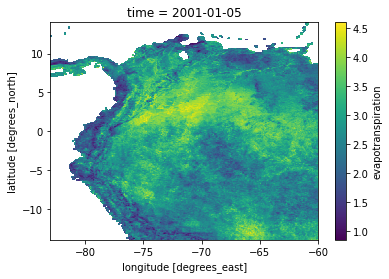

In [4]:
#first we make a simple plot of the cube we are going to work with
colombia.evapotranspiration[0,:,:].plot()

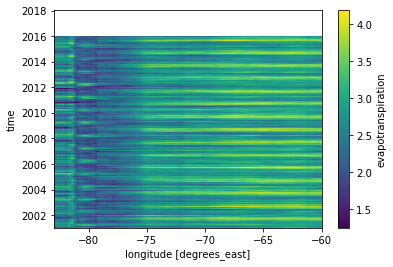

In [5]:
#Now, we can see that there might be dates with no values so we have to select the 
#correct dates where we are going to work for example if we work with evapotranspiration
ET=colombia.evapotranspiration
nantime=ET.reduce(np.nanmean,dim='lat')
nantime.plot()

In [6]:
#it is clear that the values for the dates beginning with 2016 are missing, let's select the working dates
nantime=nantime.reduce(np.nanmedian,dim='lon')
allDates=nantime['time'].values
workingDates=allDates[np.logical_not(np.isnan(nantime.values))]
#we can select the first and last so we can make slices of time
sliceDates=slice(workingDates[0],workingDates[-1])
print((workingDates[0],workingDates[-1]))

#next we select a subcube with variables without a lot of nans in an area but only in the time slice
colombia=colombia.sel(time=sliceDates)

(numpy.datetime64('2001-01-05T00:00:00.000000000'), numpy.datetime64('2015-12-31T00:00:00.000000000'))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b94973b38>,
      dtype=object)

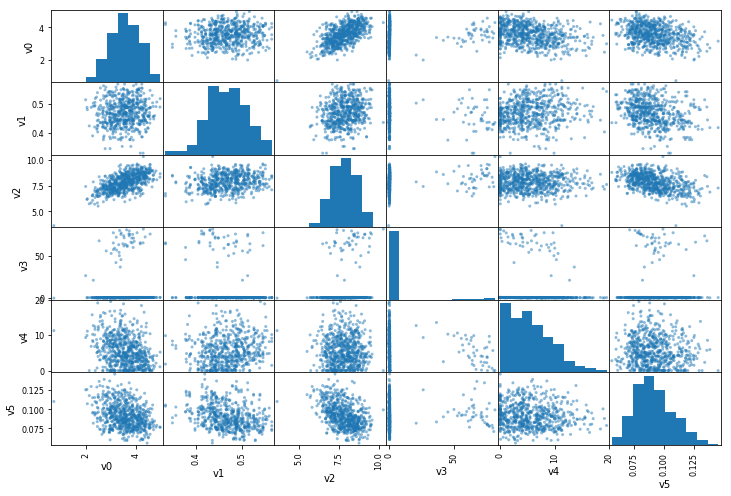

In [7]:
tmp=colombia.evapotranspiration
tmp1=colombia.enhanced_vegetation_index_aqua
tmp2=colombia.gross_primary_productivity
tmp3=colombia.fapar
tmp4=colombia.precipitation_chirps
tmp5=colombia.directional_hemispheric_reflectance_visible

#Data extraction of each variable for certain lat, lon
owe = tmp.sel(lat=5, lon=-75, method='nearest')
owe1=tmp1.sel(lat=5, lon=-75, method='nearest')
owe2=tmp2.sel(lat=5, lon=-75, method='nearest')
owe3=tmp3.sel(lat=5, lon=-75, method='nearest')
owe4=tmp4.sel(lat=5, lon=-75, method='nearest')
owe5=tmp5.sel(lat=5, lon=-75, method='nearest')
#Convertion to np array
cor=np.array(owe)
cor1=np.array(owe1)
cor2=np.array(owe2)
cor3=np.array(owe3)
cor4=np.array(owe4)
cor5=np.array(owe5)
m= pd.DataFrame({ 'v0': cor, 'v1': cor1,'v2':cor2,'v3':cor3, 'v4':cor4, 'v5':cor5})
attributes = ["v0", "v1","v2","v3","v4","v5"];
pd.plotting.scatter_matrix(m[attributes], figsize=(12,8))

De lo anterior, se pueede concluir que la Evapotranspiracion se encuentra fuertemente relacionada con GPP, por ende se escogieron como variables para trabajar de forma multivariada.

### Caracterizacion de seasonality


In [8]:
#next we select a subcube with variables without a lot of nans in an area but only in the time slice
colombia=colombia.sel(time=sliceDates)
sectionCol, features=explore_nulls(colombia,threshold=10)

bihemispheric_reflectance_near_infrared null_percentage = 0.00
bihemispheric_reflectance_shortwave null_percentage = 0.00
burn_date null_percentage = 0.00
directional_hemispheric_reflectance_near_infrared null_percentage = 0.00
directional_hemispheric_reflectance_shortwave null_percentage = 0.00
directional_hemispheric_reflectance_visible null_percentage = 0.00
enhanced_vegetation_index_terra null_percentage = 0.00
evapotranspiration null_percentage = 0.00
fapar null_percentage = 6.99
gross_primary_productivity null_percentage = 0.00
lat_bnds null_percentage = 0.00
leaf_area_index null_percentage = 0.32
lon_bnds null_percentage = 0.00
normalized_difference_vegetation_index_terra null_percentage = 0.00
precipitation_chirps null_percentage = 0.00
surface_diffuse_downwelling_photosynthetic_radiative_flux null_percentage = 0.34
surface_downwelling_photosynthetic_radiative_flux null_percentage = 0.00
surface_downwelling_shortwave_flux null_percentage = 0.34
time_bnds null_percentage = 0.00


In [10]:
#let's work with 2 very good features in the small selected region
variables=['evapotranspiration','gross_primary_productivity']
sectionCol=sectionCol[variables]

#now let's transform it into the frequency domain
freqCube=time2freqDataset(sectionCol,variables=variables)

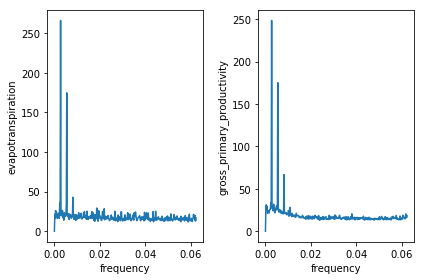

In [11]:
#since the region isn't very large and in the amazon, let's assume that it has similar frequencies to plot
#the seasonality of the region

plt.subplot(1, 2, 1)
freqET=freqCube.evapotranspiration.reduce(np.mean,dim='lon').reduce(np.mean,dim='lat')
freqET.plot()

plt.subplot(1, 2, 2)
freqGPP=freqCube.gross_primary_productivity.reduce(np.mean,dim='lon').reduce(np.mean,dim='lat')
freqGPP.plot()

plt.tight_layout()
plt.show()


En las graficas se evidenian 2 o 3 frecuencias principales que dominan la seasonality de la region. El analisis de dichas frecuencias se realizo con Transformada de Fourier, con temas que conciernen a tratamiento de señales. 
Respecto a Inteligencia Artificial, con estos resultados se aplicaron 2 tipos de aprendizaje.


### Aprendizaje No Supervisado

Aplicamos el algoritmo KDE para detección de anomalias, dada la distribución de los datos

The real latitude and longitud taken is:
2.958681499999999 -69.95877349999999


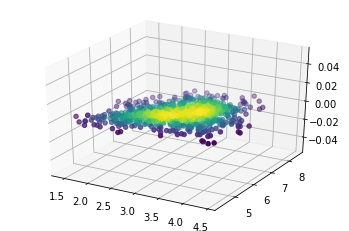

In [12]:
d=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',3,-70,3, show=True)

En la función extreme_detection se realiza el KDE, con lo que se obtienen los indices de los tiempos donde se encuentran anomalias, al identificarlos es posible etiquetarlos, por ello dicha funcion devuelve: 

1) La grafica en 3D de como se encuentran distribuidas ambas variables, el color nos muestra la densidad de cada punto, y visualmente es posible reconocer los outliers.

2) Un DataFrame de Pandas con las características (GPP, ET), su respectivo Exponential Moving Average, y la etiqueta de si corresponde o no a un evento extremo. (Dicho DataFrame se encuentra adjunto como un csv)

In [18]:
d.head(10)
#d.to_csv(r'data.csv')

,Fecha,evapotranspiration,gross_primary_productivity,EMA 1,EMA 2,Evento extremo
0,2001-01-05,4.023,5.120,4.023000,5.120000,0
1,2001-01-13,3.901,5.460,3.955900,5.307000,0
2,2001-01-21,2.502,7.811,3.371442,6.313591,0
3,2001-01-29,3.653,5.561,3.464203,6.065646,0
4,2001-02-06,2.660,6.217,3.233338,6.109096,0
5,2001-02-14,3.094,5.670,3.197147,5.995047,0
6,2001-02-22,3.907,6.186,3.368193,6.041059,0
7,2001-03-02,3.234,6.357,3.337664,6.112937,0
8,2001-03-10,3.317,5.796,3.333168,6.043983,0
9,2001-03-18,2.872,6.384,3.236297,6.115405,0


## Supervised Learning

Dado que logramos etiquetar los datos, ahora es posible tratar de predecir en base a ello. Se decidió usar Logistic Regression adicionando el feature de Exponential Moving Average para cada variable (GPP, ET) basandonos en los resultados de: (https://www.linkedin.com/pulse/weather-forecasting-using-machine-learning-models-model-kinjal-ami)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from IPython.display import Image
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()
X=d.values[:,1:-1]
y=d.values[:,-1].ravel()
y=y.astype('int')
est=lr
est.fit(X,y)
s = cross_val_score(est, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.971 (+/- 0.01449)


Ahora, para mas coordenadas, lo que se traduce en más datos para entrenar!

In [20]:
d1=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',2.5,-70,3,show=False)
d2=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',2.8,-70,3,show=False)
d3=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',3.1,-70,3,show=False)
d4=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',3.4,-70,3,show=False)
d5=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',3.7,-70,3,show=False)
d6=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',4,-70,3,show=False)
d7=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',4.3,-70,3,show=False)
d8=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',4.6,-70,3,show=False)
d9=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',4.9,-70,3,show=False)
d10=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',5.2,-70,3,show=False)
d11=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',5.5,-70,3,show=False)
d12=extreme_detection(colombia,'evapotranspiration','gross_primary_productivity',5.8,-70,3,show=False)

The real latitude and longitud taken is:
2.4586834999999994 -69.95877349999999
The real latitude and longitud taken is:
2.7920154999999998 -69.95877349999999
The real latitude and longitud taken is:
3.1253475 -69.95877349999999
The real latitude and longitud taken is:
3.375346499999999 -69.95877349999999
The real latitude and longitud taken is:
3.7086784999999995 -69.95877349999999
The real latitude and longitud taken is:
3.9586775000000003 -69.95877349999999
The real latitude and longitud taken is:
4.292009499999999 -69.95877349999999
The real latitude and longitud taken is:
4.625341499999999 -69.95877349999999
The real latitude and longitud taken is:
4.8753405 -69.95877349999999
The real latitude and longitud taken is:
5.208672499999999 -69.95877349999999
The real latitude and longitud taken is:
5.4586714999999995 -69.95877349999999
The real latitude and longitud taken is:
5.7920035 -69.95877349999999


In [21]:
new_d=pd.concat([d1, d2, d3, d4,d5,d6,d7,d8,d9,d10,d11,d12])
#new_d.to_csv(r'data2.csv')
est2 = LogisticRegression()
X2=new_d.values[:,1:-1]
y2=new_d.values[:,-1]
y2=y2.astype('int')
est2.fit(X2,y2)
s2 = cross_val_score(est2, X2, y2, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print ("accuracy %.5f (+/- %.5f)"%(np.mean(s2), np.std(s2)))
est2.coef_

accuracy 0.97101 (+/- 0.00566)


array([[ 0.30767669, -0.1085308 , -0.74297793, -0.04651568]])

Por ultimo, repetimos el proceso anterior pero usano train_test_split

In [22]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred)
print(acc_score*100)

97.28260869565217
